In [1]:
import numpy as np
from numpy.linalg import inv
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [17]:
def createModelMatrix(matrixDim,sparsity):
    #matrixDim=10
    #sparsity = 0.01
    Amat = np.zeros((matrixDim,matrixDim))
    for i in range(0,matrixDim):
        Amat[i,i] = i + 1
    Amat = Amat + sparsity*np.random.randint(20,size=(matrixDim,matrixDim)) 
    print("Amat: \n",Amat)
    u,v=LA.eig(Amat)
    print('Correct roots: ',np.sort(u))
    return Amat

def defineAllVariables(Amat,matrixDim): #defines single vector p,q,eps,H0,V from a given matrix and its dimension
    p=np.zeros((matrixDim,1))
    q=np.zeros((matrixDim,matrixDim-1))
    print(np.shape(p),np.shape(q))
    diagMat=np.diag(Amat)
    print('diagonal of Matrix: ',diagMat)
    
    newDiag=[]
    for i in range(matrixDim):
        for j in range(matrixDim):
            if i==j:
                newDiag.append(Amat[i,j])
                
    print('new diagonal of matrix: ',newDiag)
    
    lowestElements=np.argsort(diagMat)
    print('lowest element index:',lowestElements)
    print('actual lowest element of Hbar:',diagMat[lowestElements[0]])

    p[lowestElements[0],0]=1.0
    print('p',p)
    counter=0
    for i in range(len(lowestElements)):
        if i==lowestElements[0]:
            continue
        else:
            q[lowestElements[i],counter]=1.0
            counter=counter+1


        
        
    H0=np.diag(np.diag(Amat))#np.matmul(np.matmul(projP,Amat),projP)
    V=Amat-H0
    print('V \n',V)
    #print('original Guess:',diagMat[0])
    guessEps=diagMat[lowestElements[0]] #+0.01
    eps=guessEps
    print('init Guess:',eps)
    
    return p,q,H0,V,eps

def createT0_projQ(q,qDim,H0Dim,eps,H0): #qDim>0
    print('q',q,eps,qDim)
    epsMat=np.zeros((H0Dim,H0Dim))
    denom=np.zeros((H0Dim,H0Dim))
    np.fill_diagonal(epsMat,eps)
    
    sumMatrix=np.zeros((H0Dim,H0Dim))
    for i in range(qDim):
        Q=np.outer(q[:,i],q[:,i])
        #print('Q outer:',Q)
        QH0Q=np.matmul(np.matmul(Q,H0),Q)
        denom=epsMat-QH0Q
        for x in range(H0Dim):
            if (abs(denom[x,x]) < 0.0001):
                if (denom[x,x]< 0.00000000000000001):
                    factor=-1.0
                    denom[x,x]=factor*0.0001
                else:
                    factor=1.0
                    denom[x,x]=factor*0.0001
            denom[x,x]=1.0/denom[x,x]
                
        #denom=inv(denom)
        sumMatrix=sumMatrix+np.matmul(np.matmul(Q,denom),Q) #q[:,i],denom),q[:,i].T)
    print('T0 value is: ',sumMatrix)
    return sumMatrix


def extendPSpace(T0,V,p,order):
    T0V=np.matmul(T0,V)
    tmp=T0V
    
    for i in range(1,order+1):
        print('extending guess for order: ',i)
        tmp=np.matmul(tmp,T0V)
        
    correctionVec=np.matmul(tmp,p)
    print('Correction vector: \n',correctionVec)
    return correctionVec

def computeRHR(fullSpace,H,HDim,order):
    overlap=fullSpace[:,:order+1].T @ fullSpace[:,:order+1]
    print('overlap',overlap)
    s,u=LA.eig(overlap)
    print('little s:',s)
    sDiag=np.zeros((order+1,order+1))#
    np.fill_diagonal(sDiag,s)
    for i in range(order+1):
        sDiag[i,i]=1.0/np.sqrt(sDiag[i,i])
    print('sdiag:',sDiag)
        
    X=u.T @ sDiag
    X=X @ u
    RHR=(fullSpace[:,:order+1].T @ H) @ fullSpace[:,:order+1]
    Hprime=X.T @ RHR
    Hprime=Hprime @ X
    try:
        roots,vecs=LA.eig(Hprime)
        indx=roots.argsort()
        theta=roots[indx]
        vecs=vecs[:,indx] # these are C' ; must convert back to C, ie XC'=C
        transformedVecs=X@vecs # this is the back transform step
        usableRoots=[ elem for elem in theta if elem > 0.15 ]
        usableIndx=[x for x in range(len(theta)) if theta[x] > 0.15]
        print('Usable roots from <R|H|R>: ',usableRoots)
        print('Usable vecs from <R|H|R>: ',transformedVecs[:,usableIndx])
    except np.linalg.LinAlgError as err:
        print('inf or NaN inside the code performing delta^(-1/2)Hdelta^(-1/2) diagonalization!!')
        print("Formal error message: ")
        print(err)
    
    
    ## test orthogonalizing fullspace
    qq,r=LA.qr(fullSpace[:,:order+1])
    RHR=(qq.T @ H) @ qq
    print('RHR: \n',RHR)
    roots,vecs=LA.eig(RHR)
    print('Roots from <R|H|R> via QR:',np.sort(roots))
    indx=roots.argsort()
    theta=roots[indx]
    vecs=vecs[:,indx]
    print('C_i vecs: ',vecs)
    usableRoots=[ elem for elem in theta if elem > 0.15 ]
    usableIndx=[x for x in range(len(theta)) if theta[x] > 0.15]
    print('C_i vecs: ',vecs[:,usableIndx])
    return usableRoots,vecs[:,usableIndx]#usableRoots,transformedVecs[:,usableIndx]   
        
        
def runVariationalAlgo(H,Hdim):
    p,q,H0,V,eps=defineAllVariables(H,Hdim)
    print('H0:',H0)
    fullSpace=np.zeros((Hdim,Hdim))
    print('shape of FS and p',np.shape(fullSpace[:,0]),np.shape(p))
    fullSpace[:,[0]]=p
    order=0
    qDim=Hdim-1
    Hbkup=H
    print('initial guess H0: ',eps)
    finalEps=[]
    for i in range(20):
        print('*********************************')
        print('*********************************')
        print('***** Iteration: ',i)
        T0=createT0_projQ(q,qDim,Hdim,eps,H0)
        pertVec=extendPSpace(T0,V,p,order) # first order correction
        order=order+1
        fullSpace[:,[order]]=pertVec
        
        ## try orthogonalizing fullSpace
        qq,r=LA.qr(fullSpace[:,:order+1])
        fullSpace[:,:order+1]=qq
        ##
        ritzRoots,ritzVecs=computeRHR(fullSpace,H,Hdim,order)
        print('ritzVecs:',ritzVecs)
        print('ritzRoots:',np.sort(ritzRoots))
        eps=np.sort(ritzRoots)[0]
        finalEps.append(eps)
        
    return finalEps
       



In [6]:
#HeH+
cisHeH=np.loadtxt('cisHeH.txt')
print(cisHeH)
finalCisHeH=np.zeros((11,11)) #dimension of HeH+ CIS matrix; defines i and j index as well

counter=0
for i in range(11):
    for j in range(i,11):
        print('i,j:',i,j)
        finalCisHeH[i,j]=cisHeH[counter]
        finalCisHeH[j,i]=finalCisHeH[i,j]
        counter=counter+1
        
print('finalCISheH',finalCisHeH)
guessRoots,guessVecs=LA.eig(finalCisHeH)
print('HeH+ CIS roots:',np.sort(guessRoots))

runVariationalAlgo(finalCisHeH,11)

[ 8.28692379e-01  5.54853946e-02  9.41294716e-03  0.00000000e+00
  0.00000000e+00  1.00346189e-02  0.00000000e+00  0.00000000e+00
  1.02642480e-02  4.58917500e-03  4.92319800e-02  1.20240609e+00
 -4.05652551e-02  0.00000000e+00  0.00000000e+00 -3.36256815e-02
  0.00000000e+00  0.00000000e+00 -4.23616784e-02 -2.23130733e-02
  9.31659731e-04  1.63686245e+00  0.00000000e+00  0.00000000e+00
 -2.91054360e-03  0.00000000e+00  0.00000000e+00  7.95477687e-03
  1.80429220e-02  2.29463146e-03  1.78808803e+00  0.00000000e+00
  0.00000000e+00 -2.38849123e-03  3.78608309e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.78808803e+00  0.00000000e+00
 -3.78608309e-02 -2.38849123e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.12464069e+00  0.00000000e+00  0.00000000e+00
  3.86410672e-02  4.88817502e-02  8.70826803e-03  2.36104099e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.36104099e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.01429477e+00 -2.22908

[0.8197240864951993,
 0.8196499350261407,
 0.8196499205131096,
 0.8196499202744696,
 0.8196498674256114]

In [10]:
# Water CIS
# Water CIS
water=np.loadtxt('waterCIS.txt')
print(water)
finalwater=np.zeros((100,100)) #dimension of HeH+ CIS matrix; defines i and j index as well

counter=0
for i in range(100):
    for j in range(100):
        #print('i,j:',i,j)
        finalwater[i,j]=water[counter]
        counter=counter+1
        
print('water',finalwater)
guessRoots,guessVecs=LA.eig(finalwater)
print('water CIS roots:',np.sort(guessRoots))
eps=runVariationalAlgo(finalwater,100)
print('Convergence Info: ',eps)

[ 2.03589324e+01  0.00000000e+00  1.26535320e-01 ... -3.97087662e-03
  0.00000000e+00  4.29091660e+01]
water [[ 2.03589324e+01  0.00000000e+00  1.26535320e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.04157538e+01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.26535320e-01  0.00000000e+00  2.06988393e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.74422163e+00
   0.00000000e+00 -3.97087662e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   3.93693088e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.97087662e-03
   0.00000000e+00  4.29091660e+01]]
water CIS roots: [ 0.37098005  0.43294249  0.46643802  0.53947209  0.5917756   0.70385187
  0.86811614  0.91322348  0.95268039  0.95798485  1.04455771  1.10665125
  1.11080485  1.11102898  1.15256459  1.18658206  1.219577    1.23959655
  1.28745578  1.291

extending guess for order:  4
Correction vector: 
 [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 4.18883290e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.20474601e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.32106731e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.75224951e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-2.90816593e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 4.33017123e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.17997126e-03]
 [ 0.00000000e+00]

In [18]:
#water dimer
# Water DIMER CIS
water=np.loadtxt('waterDimerCIS.txt')
print(water)
finalwater=np.zeros((400,400)) #dimension of HeH+ CIS matrix; defines i and j index as well

counter=0
for i in range(400):
    for j in range(400):
        #print('i,j:',i,j)
        finalwater[i,j]=water[counter]
        counter=counter+1
        
print('water',finalwater)
guessRoots,guessVecs=LA.eig(finalwater)
print('water CIS roots:',np.sort(guessRoots))
eps=runVariationalAlgo(finalwater,400)

[ 2.03858698e+01 -6.63775542e-02  9.76401134e-06 ...  9.10180564e-05
  2.87149342e-01  4.31080244e+01]
water [[ 2.03858698e+01 -6.63775542e-02  9.76401134e-06 ... -6.84039285e-08
  -5.72244688e-07 -2.45261532e-07]
 [-6.63775542e-02  2.06779774e+01 -4.79667950e-04 ... -2.68429097e-09
   1.13027623e-07  4.79820299e-08]
 [ 9.76401134e-06 -4.79667950e-04  2.04264826e+01 ... -5.67865932e-07
   1.04906298e-04  4.36448033e-05]
 ...
 [-6.84039285e-08 -2.68429097e-09 -5.67865932e-07 ...  3.94809781e+00
   4.82079274e-04  9.10180564e-05]
 [-5.72244688e-07  1.13027623e-07  1.04906298e-04 ...  4.82079274e-04
   4.35236037e+01  2.87149342e-01]
 [-2.45261532e-07  4.79820299e-08  4.36448033e-05 ...  9.10180564e-05
   2.87149342e-01  4.31080244e+01]]
water CIS roots: [ 0.38009787  0.38330207  0.44547256  0.46771961  0.47004531  0.4791968
  0.55140005  0.56589452  0.56931695  0.58332701  0.60121499  0.62180315
  0.62875922  0.6534024   0.68489906  0.69741963  0.6975091   0.72655379
  0.73034158  0.7828

T0 value is:  [[-0.05008706  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04936481  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04998538 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.2834898   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02320026
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02342612]]
Correction vector: 
 [[ 1.04767655e-08]
 [-1.96318796e-10]
 [ 3.25652219e-06]
 [-1.21282783e-08]
 [-3.14025045e-09]
 [ 2.38514734e-06]
 [ 1.07257539e-08]
 [-1.07498108e-07]
 [ 1.77403374e-06]
 [ 1.00580802e-08]
 [-1.14669244e-08]
 [ 5.81641031e-08]
 [-3.45727387e-06]
 [ 2.57753885e-09]
 [-1.23227718e-08]
 [-3.83668039e-09]
 [ 7.39226170e-10]
 [ 6.66731916e-07]
 [-2.32796391e-08]
 [-6.15864170e-07]
 [-1.20280424e-08]
 [-7.48878101e-07]
 [-1.09324371e-08]
 [-9.65261303e-09]
 [ 3.57083233e-08]
 [-2.66561916e-06]
 [-4.81510570e-09]


T0 value is:  [[-0.0499958   0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04927616  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04989449 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28059085  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02318066
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02340614]]
extending guess for order:  1
Correction vector: 
 [[-1.57958230e-08]
 [-3.02477002e-09]
 [-1.72510576e-06]
 [ 1.91868531e-10]
 [ 1.33496375e-08]
 [-1.61122815e-06]
 [ 5.41415493e-09]
 [ 6.47919714e-08]
 [-1.14628423e-06]
 [ 2.13637377e-08]
 [ 2.43328746e-08]
 [-3.07103086e-08]
 [ 1.48745583e-06]
 [ 2.99708465e-10]
 [ 1.06044922e-08]
 [-7.82766470e-08]
 [-7.53085441e-09]
 [-2.64058273e-07]
 [ 5.64463280e-09]
 [ 1.83153237e-07]
 [ 1.05898813e-08]
 [ 1.58433508e-07]
 [ 2.11158064e-09]
 [ 5.19326807e-09]
 [-1.36388123e-08]
 [ 7.935

T0 value is:  [[-0.04998689  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926751  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988561 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28031035  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317874
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02340419]]
extending guess for order:  1
extending guess for order:  2
Correction vector: 
 [[ 1.95383650e-08]
 [ 1.79131701e-09]
 [ 3.51597462e-06]
 [-1.13002150e-08]
 [-3.47572639e-08]
 [ 2.62410424e-06]
 [-3.73477025e-09]
 [-1.20154066e-07]
 [ 1.94789253e-06]
 [-2.06868470e-08]
 [-4.03485772e-08]
 [ 8.58971612e-08]
 [-4.43418772e-06]
 [ 5.20792807e-09]
 [-1.22780131e-08]
 [-5.02832507e-08]
 [ 8.78446259e-09]
 [ 8.05025035e-07]
 [-2.36177315e-08]
 [-7.60786514e-07]
 [-2.13772142e-08]
 [-8.65083531e-07]
 [-1.21062941e-08]
 [-1.28798467e-0

T0 value is:  [[-0.04998562  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926628  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988435 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28027054  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317847
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.02340391]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
Correction vector: 
 [[-2.93282720e-08]
 [-4.61539996e-09]
 [-1.75210617e-06]
 [ 1.50543605e-09]
 [ 3.25407806e-08]
 [-1.62609285e-06]
 [ 1.49434743e-08]
 [ 6.54415140e-08]
 [-1.16436433e-06]
 [ 4.46816285e-08]
 [ 4.50562480e-08]
 [-3.86395607e-08]
 [ 1.44573300e-06]
 [ 2.75972345e-10]
 [ 1.67899148e-08]
 [-8.92233505e-08]
 [-1.52708873e-08]
 [-2.65349077e-07]
 [ 5.26797967e-09]
 [ 1.78215649e-07]
 [ 2.00167284e-08]
 [ 1.29426145e-07]
 [ 2.

T0 value is:  [[-0.04998559  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926624  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988432 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026951  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
Correction vector: 
 [[ 3.86032744e-08]
 [ 5.14783565e-09]
 [ 3.48574765e-06]
 [-1.11599175e-08]
 [-5.99877316e-08]
 [ 2.61921624e-06]
 [-1.55026886e-08]
 [-1.19960902e-07]
 [ 1.93762481e-06]
 [-4.50699126e-08]
 [-6.80683337e-08]
 [ 9.79540404e-08]
 [-4.46609787e-06]
 [ 3.63420881e-09]
 [-2.35835350e-08]
 [-5.73850176e-08]
 [ 2.12837205e-08]
 [ 8.05912107e-07]
 [-2.54997853e-08]
 [-7.63694668e-07]
 [-3.98129924

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
Correction vector: 
 [[-4.93828813e-08]
 [-7.09745257e-09]
 [-1.71020882e-06]
 [ 3.66689876e-09]
 [ 5.00647545e-08]
 [-1.59364904e-06]
 [ 2.22749663e-08]
 [ 6.36999760e-08]
 [-1.13932317e-06]
 [ 6.06179470e-08]
 [ 6.83345952e-08]
 [-4.68427615e-08]
 [ 1.38412102e-06]
 [ 3.00188475e-09]
 [ 3.16397213e-08]
 [-8.75406872e-08]
 [-2.71325107e-08]
 [-2.54140482e-07]
 [ 9.25795593e-09]
 [

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
Correction vector: 
 [[ 5.97216737e-08]
 [ 8.74315663e-09]
 [ 3.40398990e-06]
 [-1.14661644e-08]
 [-8.39927778e-08]
 [ 2.55493980e-06]
 [-2.61340310e-08]
 [-1.17680747e-07]
 [ 1.88943884e-06]
 [-6.60195330e-08]
 [-9.56149308e-08]
 [ 1.08074593e-07]
 [-4.38411211e-06]
 [ 9.86822823e-10]
 [-3.82628140e-08]
 [-6.03612230e-08]
 [ 3.51498810e-08]
 [ 7.90735

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
Correction vector: 
 [[-6.98410625e-08]
 [-9.56010381e-09]
 [-1.62275716e-06]
 [ 6.11033053e-09]
 [ 6.47927687e-08]
 [-1.52321110e-06]
 [ 2.77047320e-08]
 [ 6.05447523e-08]
 [-1.08763626e-06]
 [ 7.14844407e-08]
 [ 8.96704129e-08]
 [-5.34666738e-08]
 [ 1.28187921e-06]
 [ 6.43423293e-09]
 [ 4.79990396e-08]
 [-8.67635482e-08]

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
Correction vector: 
 [[ 7.97412266e-08]
 [ 1.21515707e-08]
 [ 3.31086536e-06]
 [-1.17757138e-08]
 [-1.05410695e-07]
 [ 2.47959054e-06]
 [-3.54916177e-08]
 [-1.14937178e-07]
 [ 1.83418535e-06]
 [-8.40361856e-08]
 [-1.20749602e-07]
 [ 1.16826124e-07]
 [-4.28090967e-06]
 [-1.82077436e-09]
 [-5.28

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
Correction vector: 
 [[-8.87601207e-08]
 [-1.18283741e-08]
 [-1.53024749e-06]
 [ 8.47168868e-09]
 [ 7.69679861e-08]
 [-1.44828452e-06]
 [ 3.18761804e-08]
 [ 5.71861959e-08]
 [-1.03289468e-06]
 [ 7.94701214e-08]
 [ 1.08420368e-07]
 [-5.89162443e-08]
 [ 1.17648596e-

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
Correction vector: 
 [[ 9.76732544e-08]
 [ 1.52330736e-08]
 [ 3.21899859e-06]
 [-1.20068335e-08]
 [-1.24132641e-07]
 [ 2.40507131e-06]
 [-4.36479654e-08]
 [-1.12171157e-07]
 [ 1.77969637e-06]
 [-9.95475002e-08]
 [-1.42923665e-07]
 [ 

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
Correction vector: 
 [[-1.05478007e-07]
 [-1.38138423e-08]
 [-1.43981521e-06]
 [ 1.06405709e-08]
 [ 8.68602654e-08]
 [-1.37495453e-06]
 [ 3.50891453e-08]
 [ 5.38591706e-08]
 [-9.79352852e-07]
 [ 8.54425

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
Correction vector: 
 [[ 1.13256444e-07]
 [ 1.79506579e-08]
 [ 3.13018423e-06]
 [-1.21298078e-08]
 [-1.40323405e-07]
 [ 2.33301135e-06]
 [-5.07277213e-08]
 [-1.09452651e-07

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
Correction vector: 
 [[-1.19865418e-07]
 [-1.54918604e-08]
 [-1.35254092e-06]
 [ 1.25899525e-08]
 [ 9.47275853e-08]
 [-1.30416377e-06]
 [ 3.

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
Correction vector: 
 [[ 1.26525243e-07]
 [ 2.03090783e-08]
 [ 3.04461309e-06]
 [-1.21379522e-08]
 [-1.5421549

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/index_tricks.py:880: ComplexWarning: Casting complex values to real discards the imaginary part
  a.flat[:end:step] = val


T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
Correction vector: 
 [[-1.32015237e-07]
 [-1.68709093e-08]
 [-1.26852232e-06]


T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
Correction vector: 
 [[ 1.37634807e-07]
 [ 2.23

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
Correction vecto

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

T0 value is:  [[-0.04998558  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.04926623  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.04988431 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.28026909  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.02317846
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.0234039 ]]
extending guess for order:  1
extending guess for order:  2
extending guess for order:  3
extending guess for order:  4
extending guess for order:  5
extending guess for order:  6
extending guess for order:  7
extending guess for order:  8
extending guess for order:  9
extending guess for order:  10
extending guess for order:  11
extending guess for order:  12
extending guess for order:  13
extending guess for order:  14
extending guess for order:  15
extending guess for order:  16
extending guess for order:  17
extending guess 

[0.3841897756506541, 0.3806234400463686, 0.38011671537488945, 0.3801035979859569, 0.3800982615583746, 0.3800982299287643, 0.38009822487956524, 0.3800982246722096, 0.3800982245342721, 0.3800982243192757, 0.3800982241363909, 0.3800982239365111, 0.38009822388029796, 0.38009822387586345, 0.3800982238757356, 0.38009822387571174, 0.38009822387570624, 0.3800982238757062, 0.38009822387570624, 0.38009822387570497]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


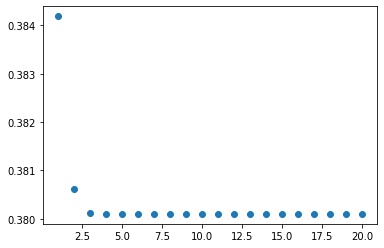

In [25]:
print(eps)
x=np.arange(1,len(eps)+1)
print(x)
plt.plot(x,eps,'o')
plt.show()

[0.004091905650654093, 0.0005255700463686064, 1.884537488944238e-05, 5.72798595688262e-06, 3.915583746127993e-07, 3.599287642930271e-07, 3.548795652341674e-07, 3.5467220960150314e-07, 3.545342721067435e-07, 3.5431927569717914e-07, 3.541363908787787e-07, 3.539365110993842e-07, 3.5388029795413445e-07, 3.5387586344581834e-07, 3.5387573560363705e-07, 3.53875711733842e-07, 3.5387570623823805e-07, 3.538757061827269e-07, 3.5387570623823805e-07, 3.538757049614816e-07]
[-2.38807439 -3.27936939 -4.72479522 -5.24199806 -6.40720348 -6.44378344
 -6.44991901 -6.45017284 -6.45034178 -6.45060522 -6.45082944 -6.45107463
 -6.45114362 -6.45114906 -6.45114921 -6.45114924 -6.45114925 -6.45114925
 -6.45114925 -6.45114925]


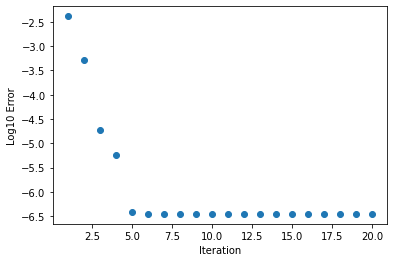

In [35]:
error=[]
for i in range(len(eps)):
    tmp=abs(0.38009787-eps[i])
    error.append(tmp)
    
print(error)
print(np.log10(error))
plt.plot(x,np.log10(error),'o')
plt.xlabel('Iteration')
plt.ylabel('Log10 Error')
plt.show()

In [16]:
0.38009787-0.3800982243192757

-3.5431927569717914e-07

In [21]:
0.38009822387570497-0.38009787

3.538757049614816e-07